In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report


In [23]:
train = pd.read_csv("./botnet/train.csv")
test = pd.read_csv("./botnet/test.csv")
df = pd.concat([train,test]).reset_index(drop=True)
list_drop = ['attack_cat']
df.drop(list_drop,axis=1,inplace=True)
test.drop(list_drop,axis=1,inplace=True)


In [24]:
df_numeric = df.select_dtypes(include=[np.number])
test_numeric = test.select_dtypes(include=[np.number])

In [25]:
def clamping(df_numeric,df):
    DEBUG =0

    for feature in df_numeric.columns:
        if DEBUG == 1:
            print(feature)
            print('max = '+str(df_numeric[feature].max()))
            print('75th = '+str(df_numeric[feature].quantile(0.95)))
            print('median = '+str(df_numeric[feature].median()))
            print(df_numeric[feature].max()>10*df_numeric[feature].median())
            print('----------------------------------------------------')
        if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
            df[feature] = np.where(df[feature]<df[feature].quantile(0.95), df[feature], df[feature].quantile(0.95))
    df_numeric = df.select_dtypes(include=[np.number])
    return df_numeric


In [26]:
df_numeric = clamping(df_numeric,df)
test_numeric = clamping(test_numeric,test)

In [27]:
df_cat = df.select_dtypes(exclude=[np.number])
test_cat = test.select_dtypes(exclude=[np.number])

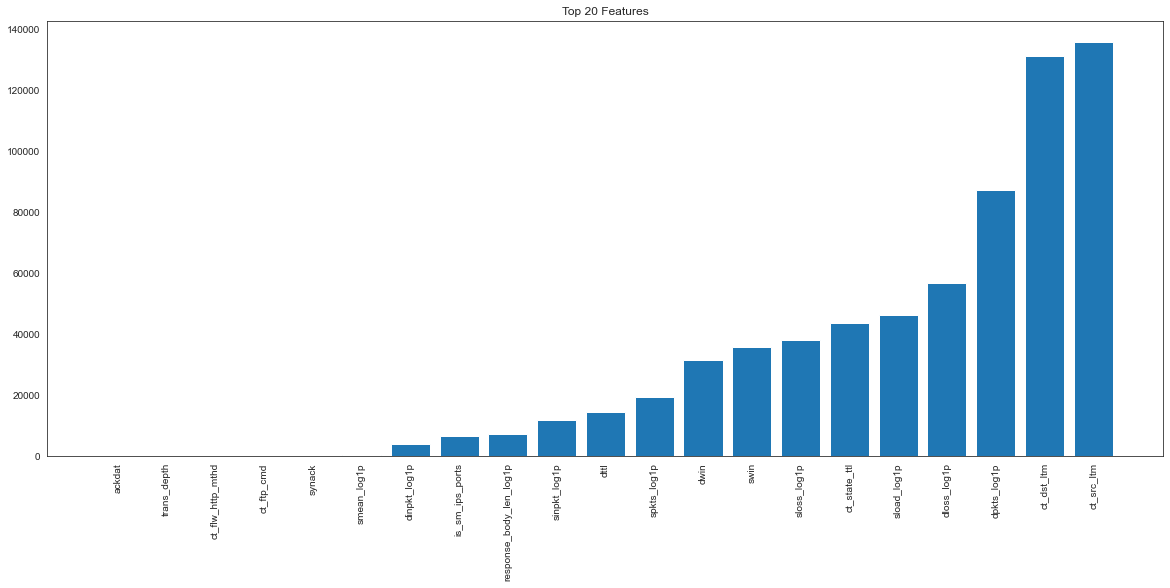

In [30]:
df_cat.describe(include='all')
best_features = SelectKBest(score_func=chi2,k='all')

X = df.drop(axis = 1,columns=['label'])
X = X.iloc[:,4:]
y = df['label']
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

plt.figure(figsize=(20,8))
plt.bar(feature_score['feature'][0:21],feature_score['score'][0:21], align='center')
plt.xticks(rotation=90)
plt.title("Top 20 Features")
plt.show()

In [7]:

X_train= df.drop(axis = 1, columns=['label'])
y_train = df['label']
X_test = test.drop(axis=1,columns=['label'])
y_test = test['label']


In [8]:
feature_names = list(X_train.columns)
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.fit_transform(X_test))


In [9]:
for label in list(df_cat['state'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat['service'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat['proto'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)


In [10]:
sc = StandardScaler()
X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])
X_test[:, 18:] = sc.transform(X_test[:, 18:])
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','Time to train','Time to predict','Total time'])
models = ['Logistic Regression', 'kNN','Random Forest', 'Gaussian Naive Bayes', 'Decision Tree(Gini Index)', 'SVM', 'XGBoost', 'Multi_layer Perceptron']
def fit_the_models(model_object,X_train,y_train,X_test,y_test):

    start = time.time()
    model = model_object.fit(X_train,y_train)
    end_train = time.time()
    y_predictions = model.predict(X_test) # These are the predictions from the test data.
    end_predict = time.time()    
    accuracy = accuracy_score(y_test, y_predictions)
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1s = f1_score(y_test, y_predictions, average='weighted')
    time_to_train = end_train - start
    time_to_predict = end_predict - end_train
    total_time = end_predict - start
    print("Accuracy: "+ "{:.2%}".format(accuracy))
    print("Recall: "+ "{:.2%}".format(recall))
    print("Precision: "+ "{:.2%}".format(precision))
    print("F1-Score: "+ "{:.2%}".format(f1s))

    return accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predictions

def plot_cm(model_object,X_test,y_test):
    plt.rcParams['figure.figsize']=5,5 
    sns.set_style("white")
    plot_confusion_matrix(model_object, X_test, y_test, cmap=plt.cm.Blues)  
    plt.show()

def print_classification_report(y_test,y_predict):
    target = ['Normal:Class 0', 'Attack:Class 1']
    print(classification_report(y_test, y_predict, target_names=target))

Accuracy: 87.16%
Recall: 87.16%
Precision: 88.39%
F1-Score: 86.90%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


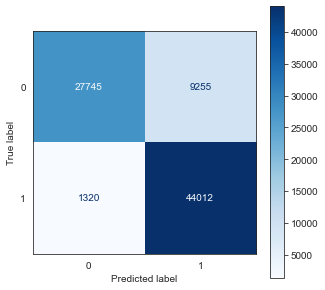

                precision    recall  f1-score   support

Normal:Class 0       0.95      0.75      0.84     37000
Attack:Class 1       0.83      0.97      0.89     45332

      accuracy                           0.87     82332
     macro avg       0.89      0.86      0.87     82332
  weighted avg       0.88      0.87      0.87     82332



In [11]:
lr = LogisticRegression(max_iter=1000)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(lr,X_train,y_train,X_test,y_test)
plot_cm(lr,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Logistic Regression'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

Accuracy: 79.35%
Recall: 79.35%
Precision: 84.94%
F1-Score: 77.91%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


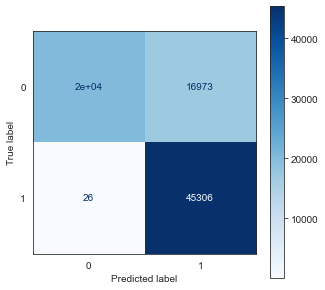

                precision    recall  f1-score   support

Normal:Class 0       1.00      0.54      0.70     37000
Attack:Class 1       0.73      1.00      0.84     45332

      accuracy                           0.79     82332
     macro avg       0.86      0.77      0.77     82332
  weighted avg       0.85      0.79      0.78     82332



In [12]:
rf = RandomForestClassifier(max_depth=3)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(rf,X_train,y_train,X_test,y_test)
plot_cm(rf,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Random Forest'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

Accuracy: 95.92%
Recall: 95.92%
Precision: 95.99%
F1-Score: 95.91%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


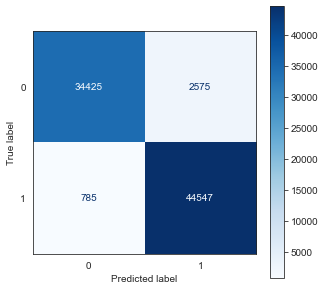

                precision    recall  f1-score   support

Normal:Class 0       0.98      0.93      0.95     37000
Attack:Class 1       0.95      0.98      0.96     45332

      accuracy                           0.96     82332
     macro avg       0.96      0.96      0.96     82332
  weighted avg       0.96      0.96      0.96     82332



In [13]:
kNN = KNeighborsClassifier(n_neighbors=3)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(kNN,X_train,y_train,X_test,y_test)
plot_cm(kNN,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['kNN'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

Accuracy: 77.40%
Recall: 77.40%
Precision: 80.19%
F1-Score: 77.29%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


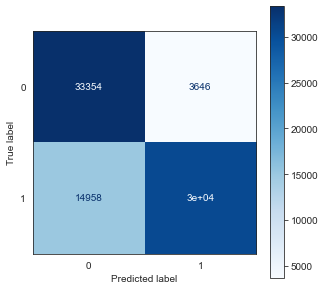

                precision    recall  f1-score   support

Normal:Class 0       0.69      0.90      0.78     37000
Attack:Class 1       0.89      0.67      0.77     45332

      accuracy                           0.77     82332
     macro avg       0.79      0.79      0.77     82332
  weighted avg       0.80      0.77      0.77     82332



In [14]:
nb = GaussianNB()
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(nb,X_train,y_train,X_test,y_test)
plot_cm(nb,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Gaussian Naive Bayes'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]


Accuracy: 91.44%
Recall: 91.44%
Precision: 91.50%
F1-Score: 91.45%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


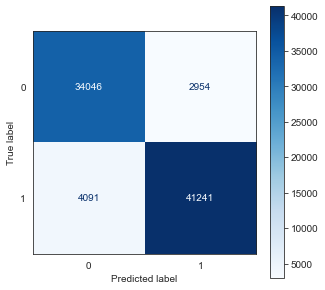

                precision    recall  f1-score   support

Normal:Class 0       0.89      0.92      0.91     37000
Attack:Class 1       0.93      0.91      0.92     45332

      accuracy                           0.91     82332
     macro avg       0.91      0.91      0.91     82332
  weighted avg       0.91      0.91      0.91     82332



In [15]:
dtree_ig = DecisionTreeClassifier(criterion='entropy',max_depth=5)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(dtree_ig,X_train,y_train,X_test,y_test)
plot_cm(dtree_ig,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Decision Tree (Information Gain)'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]


Accuracy: 91.66%
Recall: 91.66%
Precision: 91.72%
F1-Score: 91.63%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


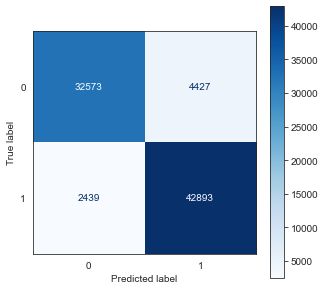

                precision    recall  f1-score   support

Normal:Class 0       0.93      0.88      0.90     37000
Attack:Class 1       0.91      0.95      0.93     45332

      accuracy                           0.92     82332
     macro avg       0.92      0.91      0.92     82332
  weighted avg       0.92      0.92      0.92     82332



In [16]:
dtree_gini = DecisionTreeClassifier(criterion='gini',max_depth=5)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(dtree_gini,X_train,y_train,X_test,y_test)
plot_cm(dtree_gini,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Decision Tree (Gini Index)'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 86.57%
Recall: 86.57%
Precision: 88.15%
F1-Score: 86.25%


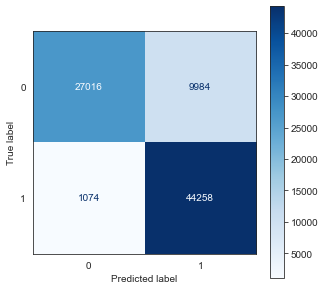

                precision    recall  f1-score   support

Normal:Class 0       0.96      0.73      0.83     37000
Attack:Class 1       0.82      0.98      0.89     45332

      accuracy                           0.87     82332
     macro avg       0.89      0.85      0.86     82332
  weighted avg       0.88      0.87      0.86     82332



In [17]:
svc =  LinearSVC()
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(svc,X_train,y_train,X_test,y_test)
plot_cm(svc,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['SVM'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 95.90%
Recall: 95.90%
Precision: 96.03%
F1-Score: 95.89%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


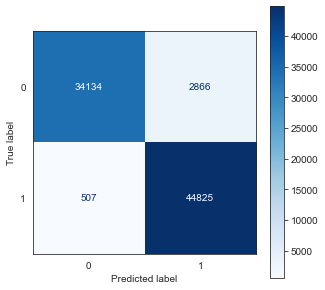

                precision    recall  f1-score   support

Normal:Class 0       0.99      0.92      0.95     37000
Attack:Class 1       0.94      0.99      0.96     45332

      accuracy                           0.96     82332
     macro avg       0.96      0.96      0.96     82332
  weighted avg       0.96      0.96      0.96     82332



In [18]:
xgb = XGBClassifier()
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(xgb,X_train,y_train,X_test,y_test)
plot_cm(xgb,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['XGBoost'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

Accuracy: 94.49%
Recall: 94.49%
Precision: 94.68%
F1-Score: 94.46%


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


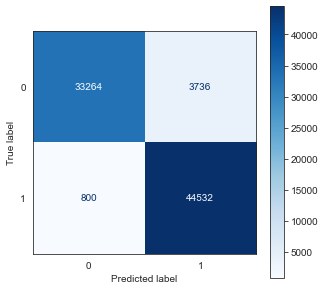

                precision    recall  f1-score   support

Normal:Class 0       0.98      0.90      0.94     37000
Attack:Class 1       0.92      0.98      0.95     45332

      accuracy                           0.94     82332
     macro avg       0.95      0.94      0.94     82332
  weighted avg       0.95      0.94      0.94     82332



In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time , y_predict = fit_the_models(mlp,X_train,y_train,X_test,y_test)
plot_cm(mlp,X_test,y_test)
print_classification_report(y_test,y_predict)
model_performance.loc['Multi-Layer Perceptron'] = [accuracy , recall , precision , f1s , time_to_train , time_to_predict , total_time]

In [20]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'Time to train':'{:.1f}',
                                                                     'Time to predict':'{:.1f}',
                                                                     'Total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,Time to train,Time to predict,Total time
Logistic Regression,87.16%,87.16%,88.39%,86.90%,34.8,0.0,34.8
Random Forest,79.35%,79.35%,84.94%,77.91%,13.1,0.4,13.5
kNN,95.92%,95.92%,95.99%,95.91%,0.0,390.8,390.9
Gaussian Naive Bayes,77.40%,77.40%,80.19%,77.29%,0.3,0.1,0.4
Decision Tree (Information Gain),91.44%,91.44%,91.50%,91.45%,2.8,0.0,2.8
Decision Tree (Gini Index),91.66%,91.66%,91.72%,91.63%,2.0,0.0,2.0
SVM,86.57%,86.57%,88.15%,86.25%,50.4,0.1,50.5
XGBoost,95.90%,95.90%,96.03%,95.89%,28.8,0.1,28.9
Multi-Layer Perceptron,94.49%,94.49%,94.68%,94.46%,59.8,0.1,59.9
